##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train Your Own Model and Convert It to TFLite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c04_exercise_convert_model_to_tflite_solution.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c04_exercise_convert_model_to_tflite_solution.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

This notebook uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing we'll use here.

This uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

# Setup

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pathlib


print(tf.__version__)

2.12.0


# Download Fashion MNIST Dataset

In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
splits, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, 
                         split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'])

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
with open('labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

In [6]:
IMG_SIZE = 28

# Preprocessing data

## Preprocess

In [7]:
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = image / 255.0
  return image, label

In [8]:
BATCH_SIZE = 32

## Create a Dataset from images and labels

In [9]:
train_batches = train_examples.cache().shuffle(num_examples//4).batch(BATCH_SIZE).map(format_example).prefetch(1)
validation_batches = validation_examples.cache().batch(BATCH_SIZE).map(format_example).prefetch(1)
test_batches = test_examples.cache().batch(1).map(format_example)

# Building the model

In [10]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10)
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

## Train

In [11]:
validation_batches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [12]:
train_batches, 

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,)

In [13]:
model.fit(train_batches, 
          epochs=10,
          validation_data=validation_batches)

Epoch 1/10
1500/1500 [==============================] - 23s 6ms/step - loss: 0.4423 - accuracy: 0.8423 - val_loss: 0.3300 - val_accuracy: 0.8812
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2966 - accuracy: 0.8919 - val_loss: 0.2626 - val_accuracy: 0.9007
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2490 - accuracy: 0.9071 - val_loss: 0.2499 - val_accuracy: 0.9082
Epoch 4/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2151 - accuracy: 0.9216 - val_loss: 0.2406 - val_accuracy: 0.9113
Epoch 5/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.1860 - accuracy: 0.9311 - val_loss: 0.2392 - val_accuracy: 0.9112
Epoch 6/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1598 - accuracy: 0.9414 - val_loss: 0.2265 - val_accuracy: 0.9197
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1372 - accuracy: 0.9500 - val_loss: 0.2276 - val_accuracy

# Exporting to TFLite

In [14]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

In [15]:
optimization = tf.lite.Optimize.DEFAULT

In [16]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [optimization]
tflite_model = converter.convert()

In [17]:
tflite_model_file = 'model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

# Test the model with TFLite interpreter 

In [18]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [19]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(50):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  test_labels.append(label[0])
  test_images.append(np.array(img))

In [20]:
#@title Utility functions for plotting
# Utilities for plotting

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label.numpy():
    color = 'green'
  else:
    color = 'red'
    
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks(list(range(10)), class_names, rotation='vertical')
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array[0])

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('green')

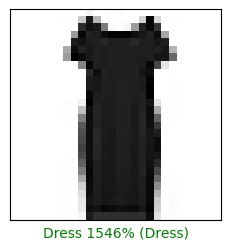

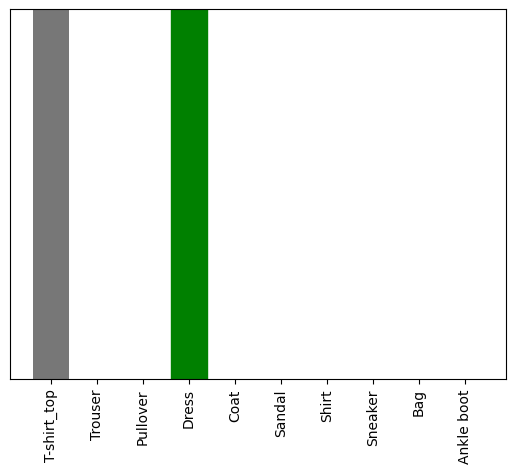

In [21]:
#@title Visualize the outputs { run: "auto" }
index = 12 #@param {type:"slider", min:1, max:50, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.show()
plot_value_array(index, predictions, test_labels)
plt.show()

# Download TFLite model and assets

**NOTE: You might have to run to the cell below twice**

In [22]:
try:
  from google.colab import files

  files.download(tflite_model_file)
  files.download('labels.txt')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Prepare the test images for download (Optional)

In [23]:
!mkdir -p test_images

In [24]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
  image = tf.cast(image * 255.0, tf.uint8)
  image = tf.squeeze(image).numpy()
  pil_image = Image.fromarray(image)
  pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]].lower(), index))

In [25]:
!ls test_images

'ankle boot_10.jpg'   coat_40.jpg       sandal_19.jpg	 sneaker_43.jpg
'ankle boot_32.jpg'   coat_46.jpg       sandal_2.jpg	 trouser_20.jpg
'ankle boot_4.jpg'    coat_48.jpg       sandal_39.jpg	 trouser_22.jpg
 bag_16.jpg	      dress_12.jpg      shirt_27.jpg	 trouser_35.jpg
 bag_17.jpg	      dress_29.jpg      shirt_33.jpg	 trouser_49.jpg
 bag_23.jpg	      dress_37.jpg      shirt_5.jpg	 t-shirt_top_15.jpg
 bag_34.jpg	      dress_45.jpg      sneaker_13.jpg	 t-shirt_top_18.jpg
 bag_36.jpg	      dress_6.jpg       sneaker_24.jpg	 t-shirt_top_1.jpg
 bag_3.jpg	      pullover_28.jpg   sneaker_25.jpg	 t-shirt_top_21.jpg
 bag_7.jpg	      pullover_44.jpg   sneaker_26.jpg	 t-shirt_top_47.jpg
 coat_11.jpg	      pullover_9.jpg    sneaker_38.jpg	 t-shirt_top_8.jpg
 coat_30.jpg	      sandal_0.jpg      sneaker_41.jpg
 coat_31.jpg	      sandal_14.jpg     sneaker_42.jpg


In [26]:
!zip -qq fmnist_test_images.zip -r test_images/

In [27]:
try:
  files.download('fmnist_test_images.zip')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>